In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from transformer_checker.dyck_k_generator import constants

In [3]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [7]:
k = 1

In [8]:
from transformer_checker.dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=10_000,
    k=k,
    min_length=0,
    max_length=16,
    balanced=0.5,
)

File data/dyck-1_10000-samples_16-len_p05.jsonl already exists.


In [9]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()'

In [10]:
from transformer_checker.dataset.dataset import DyckLanguageDataset

In [12]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 10000 samples from data/dyck-1_10000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 10000/10000 [00:00<00:00, 601040.93it/s]


In [13]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [14]:
from torch.utils.data import DataLoader

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Hooked Transformer (Bidirectional mask) - Dyck-1 dataset


In [16]:
from transformer_checker.transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    causal_mask,
    pad_token_mask,
)

In [17]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [18]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [19]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [20]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-5)

In [19]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=20,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6124 | Train Accuracy: 63.03%
Train Loss: 0.3866 | Train Accuracy: 71.75%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 13.6341 | Validation Accuracy: 100.00%
Train Loss: 127.9338 | Train Acc: 75.84%
Val Loss: 20.5094 | Val Acc: 100.00%
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1027 | Train Accuracy: 97.78%
Train Loss: 0.0353 | Train Accuracy: 98.73%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.4879 | Validation Accuracy: 100.00%
Train Loss: 21.8526 | Train Acc: 98.96%
Val Loss: 0.7350 | Val Acc: 100.00%
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0106 | Train Accuracy: 99.91%
Train Loss: 0.0108 | Train Accuracy: 99.92%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.1078 | Validation Accuracy: 100.00%
Train Loss: 3.7792 | Train Acc: 99.90%
Val Loss: 0.1626 | Val Acc: 100.00%
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0056 | Train Accuracy: 99.97%
Train Loss: 0.0034 | Train Accuracy: 99.89%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0517 | Validation Accuracy: 100.00%
Train Loss: 1.9514 | Train Acc: 99.91%
Val Loss: 0.0768 | Val Acc: 100.00%
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0025 | Train Accuracy: 100.00%
Train Loss: 0.0014 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0248 | Validation Accuracy: 100.00%
Train Loss: 0.6710 | Train Acc: 100.00%
Val Loss: 0.0377 | Val Acc: 100.00%
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0021 | Train Accuracy: 99.84%
Train Loss: 0.0012 | Train Accuracy: 99.92%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0157 | Validation Accuracy: 100.00%
Train Loss: 0.7203 | Train Acc: 99.94%
Val Loss: 0.0238 | Val Acc: 100.00%
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%
Train Loss: 0.0006 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0113 | Validation Accuracy: 100.00%
Train Loss: 0.3132 | Train Acc: 100.00%
Val Loss: 0.0168 | Val Acc: 100.00%
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0012 | Train Accuracy: 100.00%
Train Loss: 0.0009 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0091 | Validation Accuracy: 100.00%
Train Loss: 0.3244 | Train Acc: 99.98%
Val Loss: 0.0135 | Val Acc: 100.00%
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 99.94%
Train Loss: 0.0006 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0065 | Validation Accuracy: 100.00%
Train Loss: 0.2844 | Train Acc: 99.98%
Val Loss: 0.0099 | Val Acc: 100.00%
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0052 | Validation Accuracy: 100.00%
Train Loss: 0.1191 | Train Acc: 100.00%
Val Loss: 0.0078 | Val Acc: 100.00%
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0042 | Validation Accuracy: 100.00%
Train Loss: 0.0880 | Train Acc: 100.00%
Val Loss: 0.0062 | Val Acc: 100.00%
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0035 | Validation Accuracy: 100.00%
Train Loss: 0.0708 | Train Acc: 100.00%
Val Loss: 0.0051 | Val Acc: 100.00%
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0028 | Validation Accuracy: 100.00%
Train Loss: 0.0620 | Train Acc: 100.00%
Val Loss: 0.0042 | Val Acc: 100.00%
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0024 | Validation Accuracy: 100.00%
Train Loss: 0.0475 | Train Acc: 100.00%
Val Loss: 0.0036 | Val Acc: 100.00%
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0020 | Validation Accuracy: 100.00%
Train Loss: 0.0410 | Train Acc: 100.00%
Val Loss: 0.0030 | Val Acc: 100.00%
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0017 | Validation Accuracy: 100.00%
Train Loss: 0.0349 | Train Acc: 100.00%
Val Loss: 0.0026 | Val Acc: 100.00%
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0015 | Validation Accuracy: 100.00%
Train Loss: 0.0320 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0014 | Validation Accuracy: 100.00%
Train Loss: 0.0295 | Train Acc: 100.00%
Val Loss: 0.0021 | Val Acc: 100.00%
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Train Loss: 0.0239 | Train Acc: 100.00%
Val Loss: 0.0016 | Val Acc: 100.00%
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Train Loss: 0.0203 | Train Acc: 100.00%
Val Loss: 0.0014 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.0010 | Test Accuracy: 100.00%
Test Loss: 0.0020 | Test Accuracy: 100.00%
Test Loss: 0.0020 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▂▁▂█▁▇▂▇▃▇▂▂▁▁▂▂▃▁▁▁▁▇▂▆▂▂▁▁▂▂▁▃▆▃▂▂▃▇▇▂
test_acc,▁
test_loss,▁
train/acc,▁▂▇█████████████████████████████████████
train/loss,██▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,1e-05
test_acc,100.0


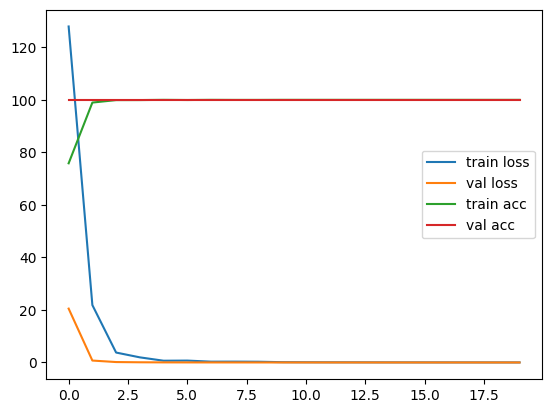

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Hooked Transformer (causal mask) - Dyck-1 dataset

In [22]:
model_causal = TransformerClassifier(model_config).to(device)

In [23]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-4)

In [24]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7217 | Train Accuracy: 50.53%
Train Loss: 0.7082 | Train Accuracy: 50.84%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 73.0823 | Validation Accuracy: 48.88%
Train Loss: 177.9722 | Train Acc: 50.32%
Val Loss: 109.2104 | Val Acc: 49.42%
Epoch 2/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6764 | Train Accuracy: 52.00%
Train Loss: 0.7179 | Train Accuracy: 50.50%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3242 | Validation Accuracy: 50.38%
Train Loss: 174.6800 | Train Acc: 50.76%
Val Loss: 104.0528 | Val Acc: 49.42%
Epoch 3/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6974 | Train Accuracy: 50.47%
Train Loss: 0.6973 | Train Accuracy: 50.28%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.8740 | Validation Accuracy: 50.50%
Train Loss: 174.7599 | Train Acc: 50.22%
Val Loss: 104.7818 | Val Acc: 50.58%
Epoch 4/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7327 | Train Accuracy: 50.03%
Train Loss: 0.7131 | Train Accuracy: 50.62%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3372 | Validation Accuracy: 49.25%
Train Loss: 174.4273 | Train Acc: 50.29%
Val Loss: 104.0003 | Val Acc: 49.42%
Epoch 5/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6981 | Train Accuracy: 50.22%
Train Loss: 0.7196 | Train Accuracy: 50.02%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.4339 | Validation Accuracy: 50.25%
Train Loss: 174.5978 | Train Acc: 50.52%
Val Loss: 104.0967 | Val Acc: 50.58%
Epoch 6/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6991 | Train Accuracy: 50.00%
Train Loss: 0.6872 | Train Accuracy: 49.86%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.2483 | Validation Accuracy: 52.38%
Train Loss: 174.1223 | Train Acc: 49.74%
Val Loss: 103.9640 | Val Acc: 50.58%
Epoch 7/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6965 | Train Accuracy: 49.91%
Train Loss: 0.7063 | Train Accuracy: 50.02%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3557 | Validation Accuracy: 48.25%
Train Loss: 173.7802 | Train Acc: 50.04%
Val Loss: 103.9620 | Val Acc: 50.58%
Epoch 8/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6981 | Train Accuracy: 49.50%
Train Loss: 0.7036 | Train Accuracy: 50.33%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.4093 | Validation Accuracy: 51.62%
Train Loss: 173.7137 | Train Acc: 50.11%
Val Loss: 104.3855 | Val Acc: 50.58%
Epoch 9/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7047 | Train Accuracy: 49.62%
Train Loss: 0.7076 | Train Accuracy: 49.50%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3293 | Validation Accuracy: 50.62%
Train Loss: 174.2303 | Train Acc: 49.12%
Val Loss: 103.9982 | Val Acc: 50.58%
Epoch 10/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7008 | Train Accuracy: 51.56%
Train Loss: 0.6984 | Train Accuracy: 50.89%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3360 | Validation Accuracy: 49.62%
Train Loss: 173.8594 | Train Acc: 50.42%
Val Loss: 104.0131 | Val Acc: 49.42%


In [25]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 69.2384 | Test Accuracy: 53.00%
Test Loss: 138.5202 | Test Accuracy: 52.25%
Test Loss: 138.5202 | Test Acc: 52.25%


test/acc,▁█▅▅▆▆▆▆▆▆▇▇▆▆▆▆▆▆▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
test/loss,▆▆▆▆▆▁▆▃▁▃▃▆█▆█▆▃▃▆▆▆▆█▁▆▆▆▆█▆▃▃▆▃▆█▁▁▆█
test_acc,▁
test_loss,▁
train/acc,▄▄▄▄▃▇▄▄▂▃▃▃▂▂▄▄█▃▂▃▆▃▂▂▃▂▃▃▁▂▃▃▁▂▂▁▂▅▅▃
train/loss,▅▁▆█▂▆▄▄▅▄▄▃▃▃▃▃▃▃▄▃▄▃▄▃▃▃▃▃▃▄▃▃▅▃▃▃▄▃▃▃
val/acc,▅▅▅▄▄▄▅▄█▅▅▄▃▃▄▄▆▃▅▅▅▆▆▅▁▄▃▄▇▄▆▄▂▄▄▅▃▄▄▃
val/loss,▅▅██▃▄▃▃▂▄▁▂▄▄▃▃▄▅▅▂▄▃▄▃▃▃▃▃▃▃▂▃▃▃▄▃▃▄▄▄
test/acc,52.25
test/loss,0.70048
test_acc,52.25


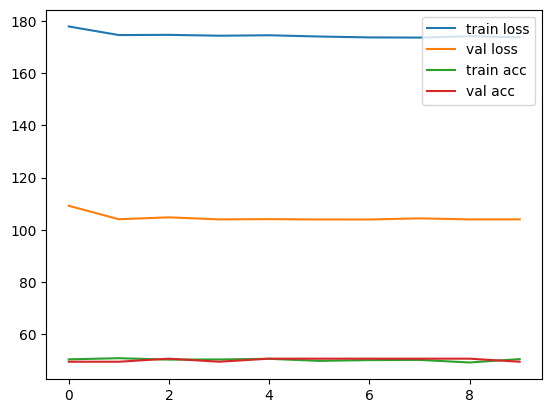

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Attention plots:


In [21]:
from transformer_checker.transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [22]:
from transformer_checker.dataset.dataset import DyckLanguageTokenizer
from transformer_checker.dyck_k_generator.checker import is_dyck_word

In [29]:
batch = next(iter(test_dataloader))

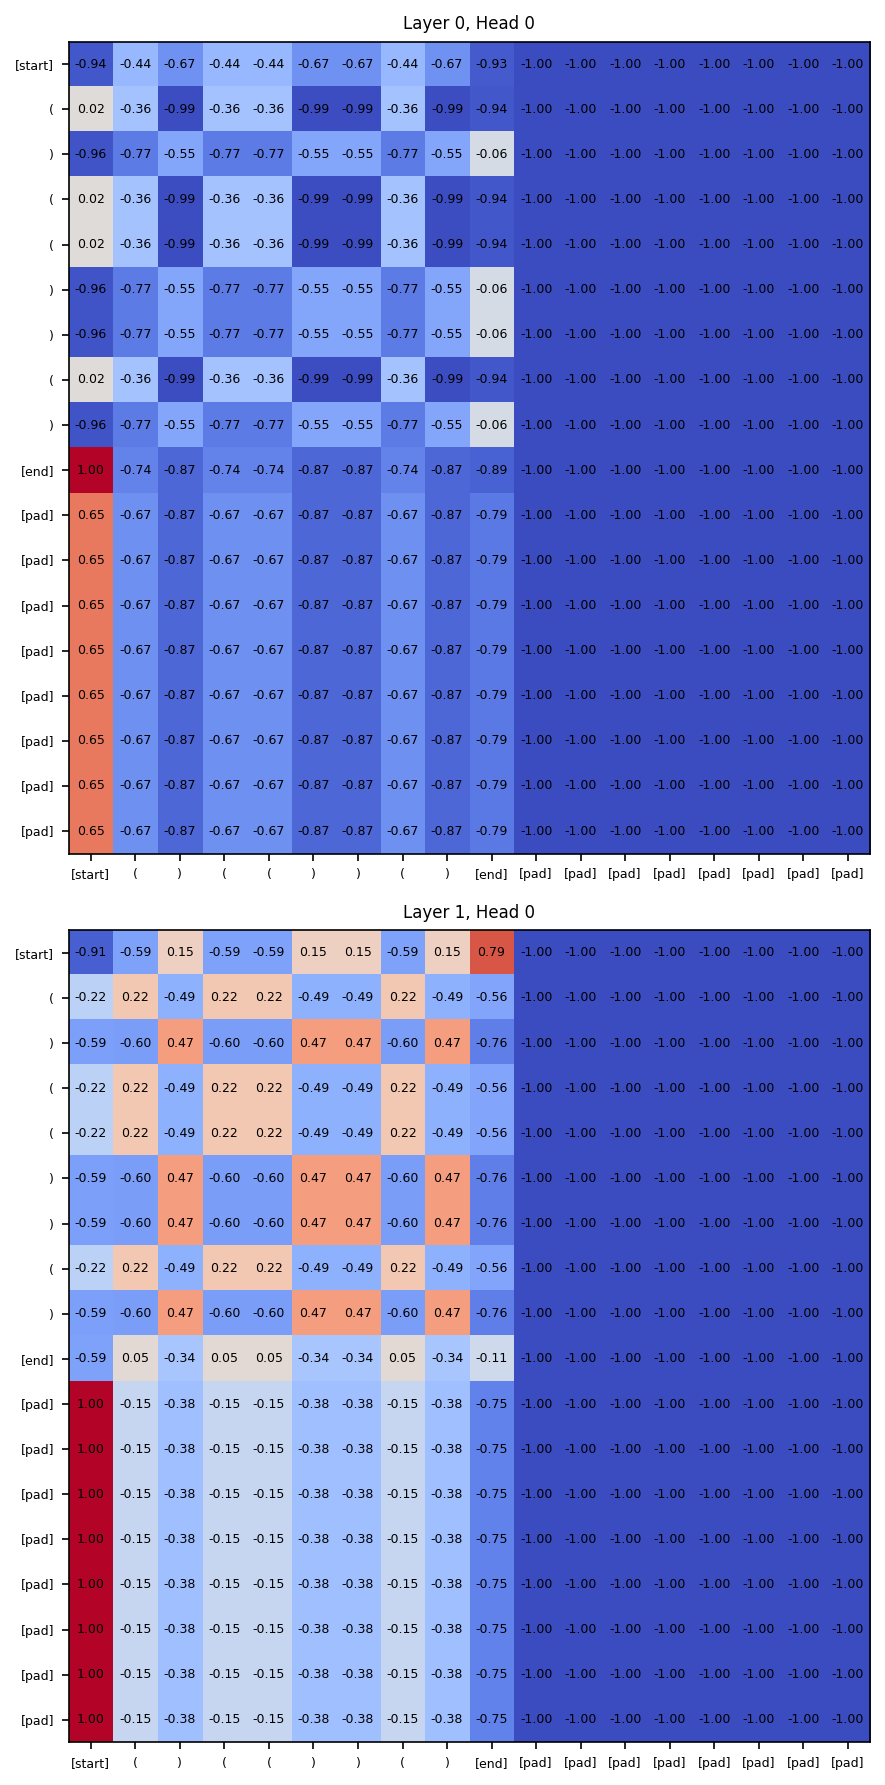

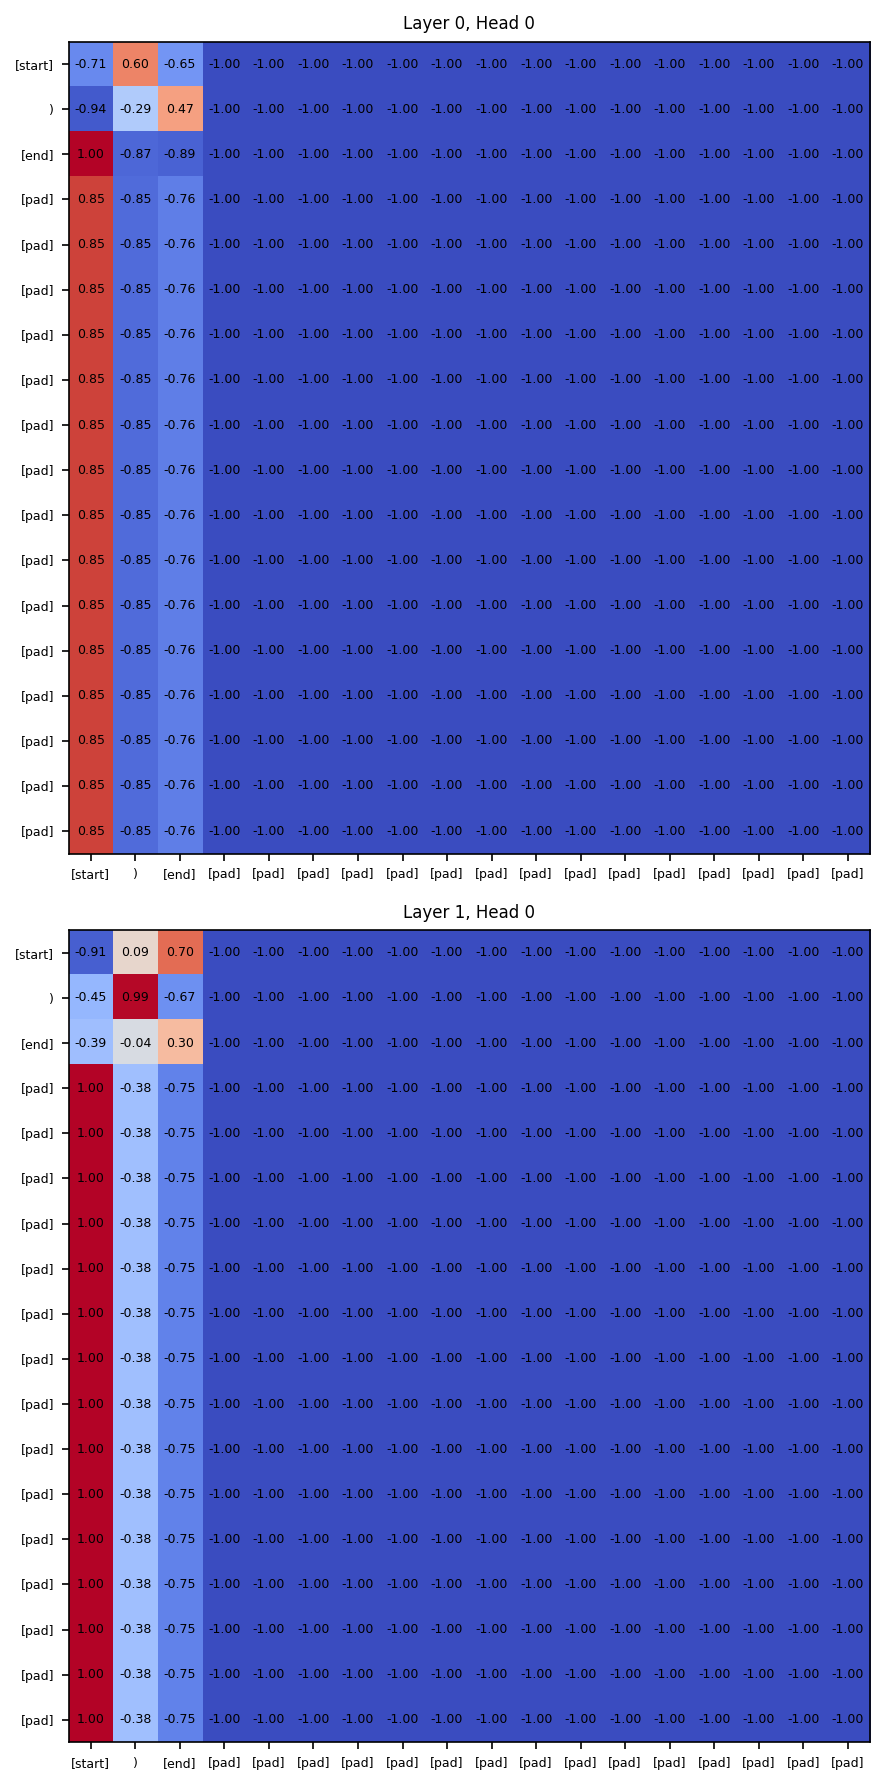

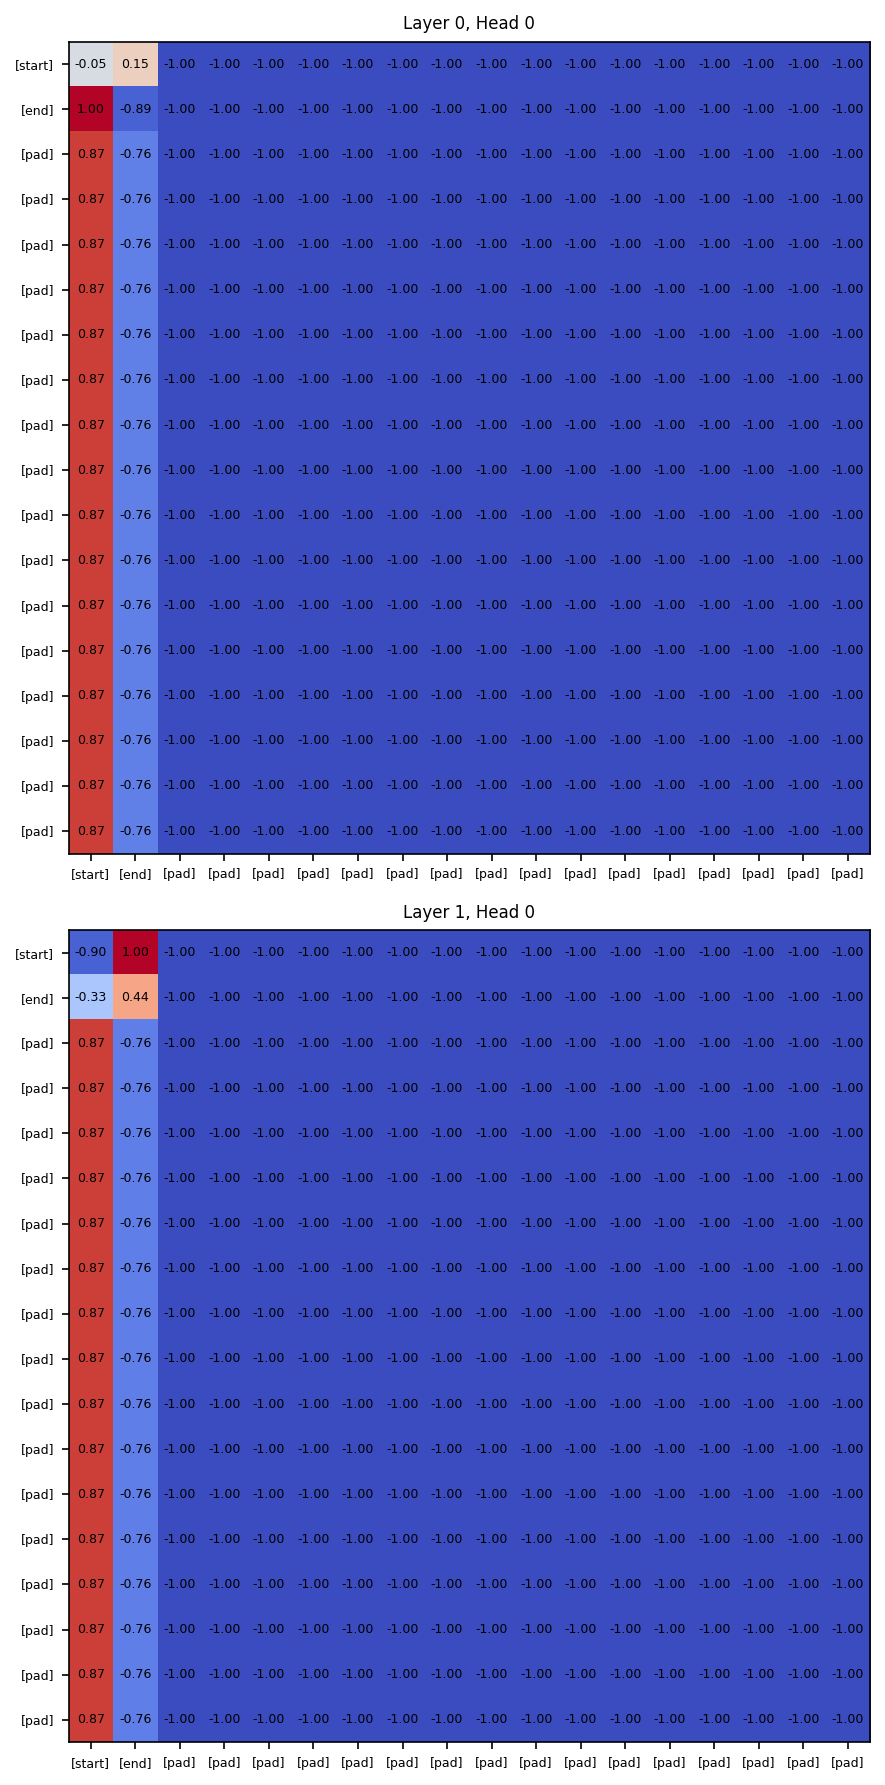

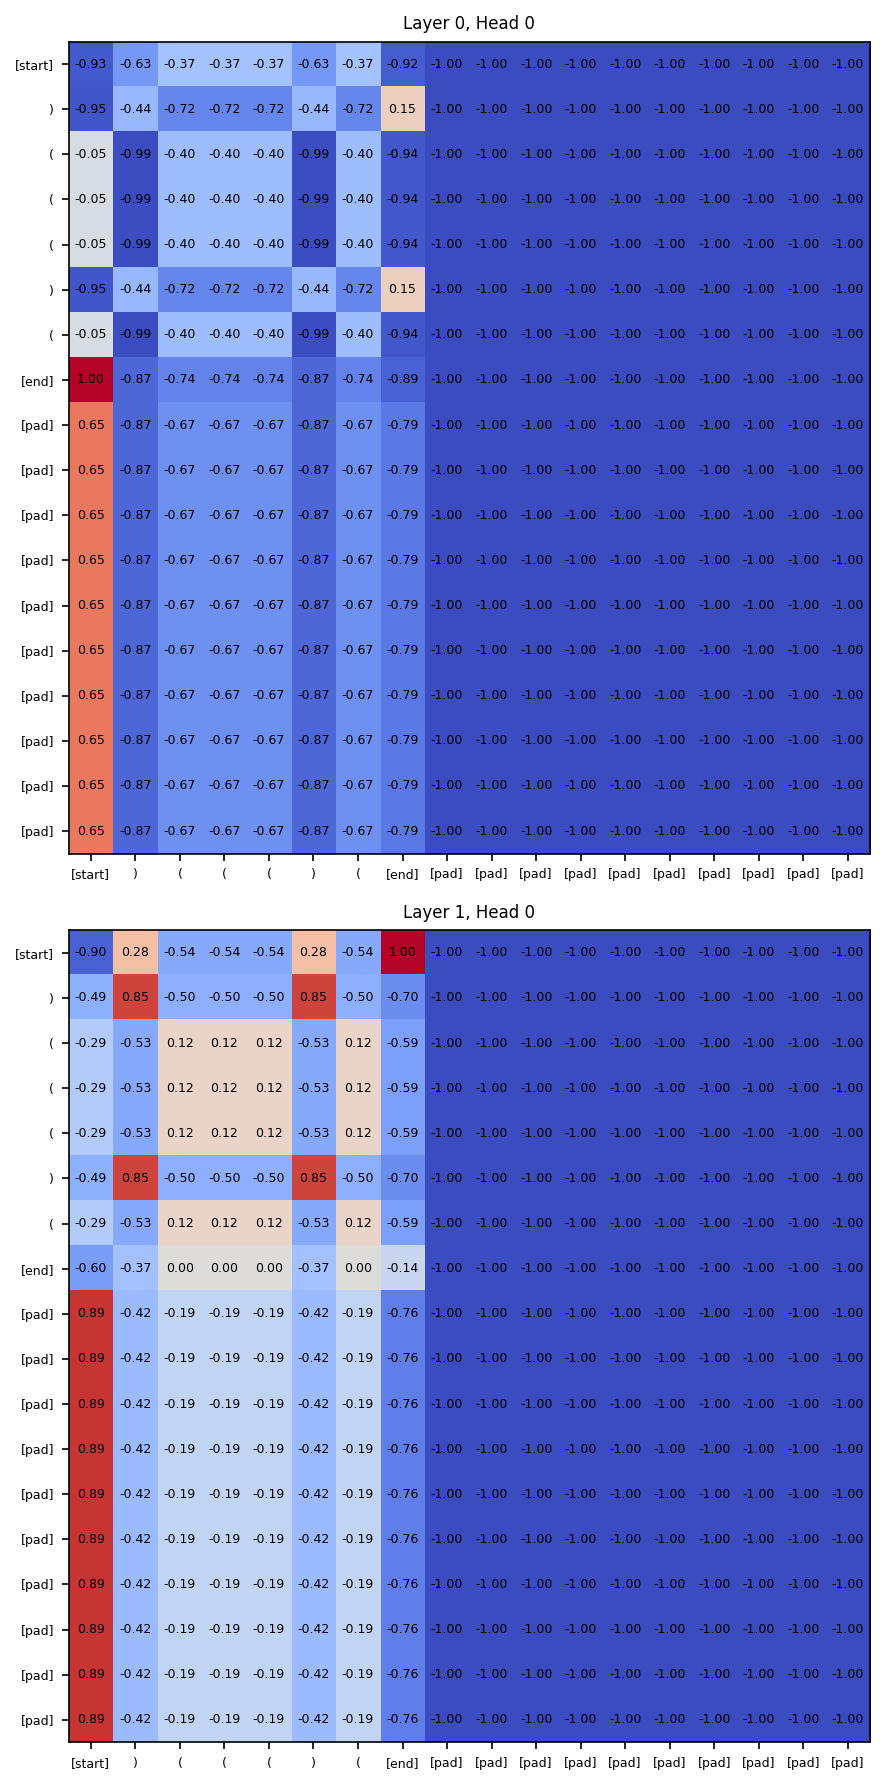

In [30]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

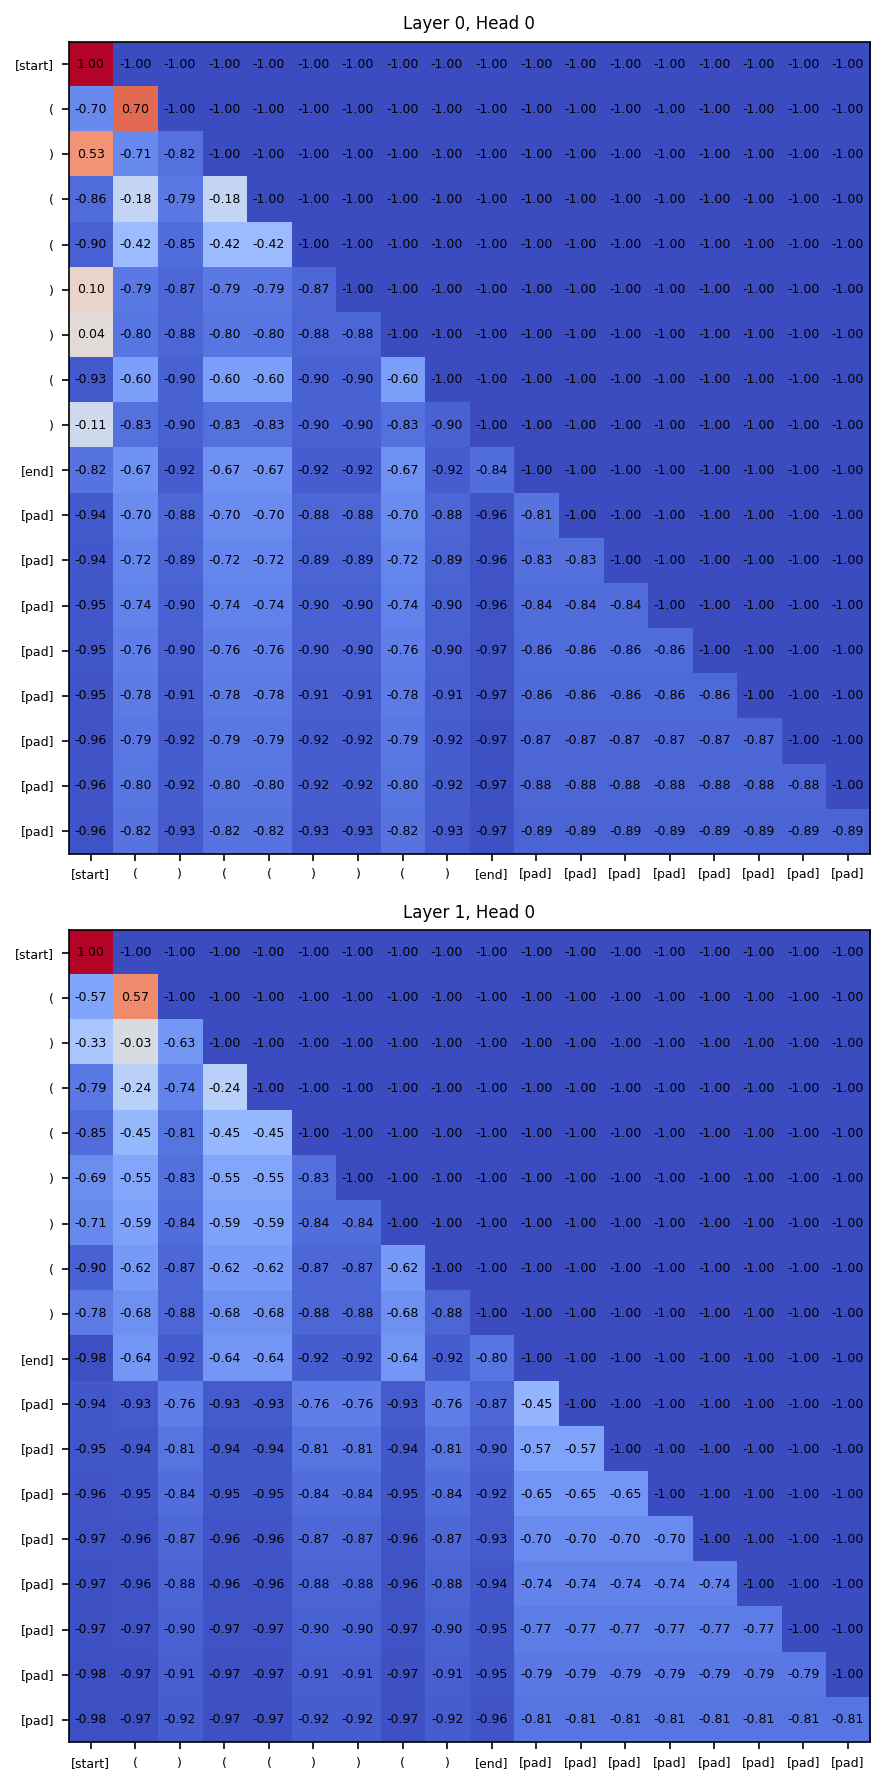

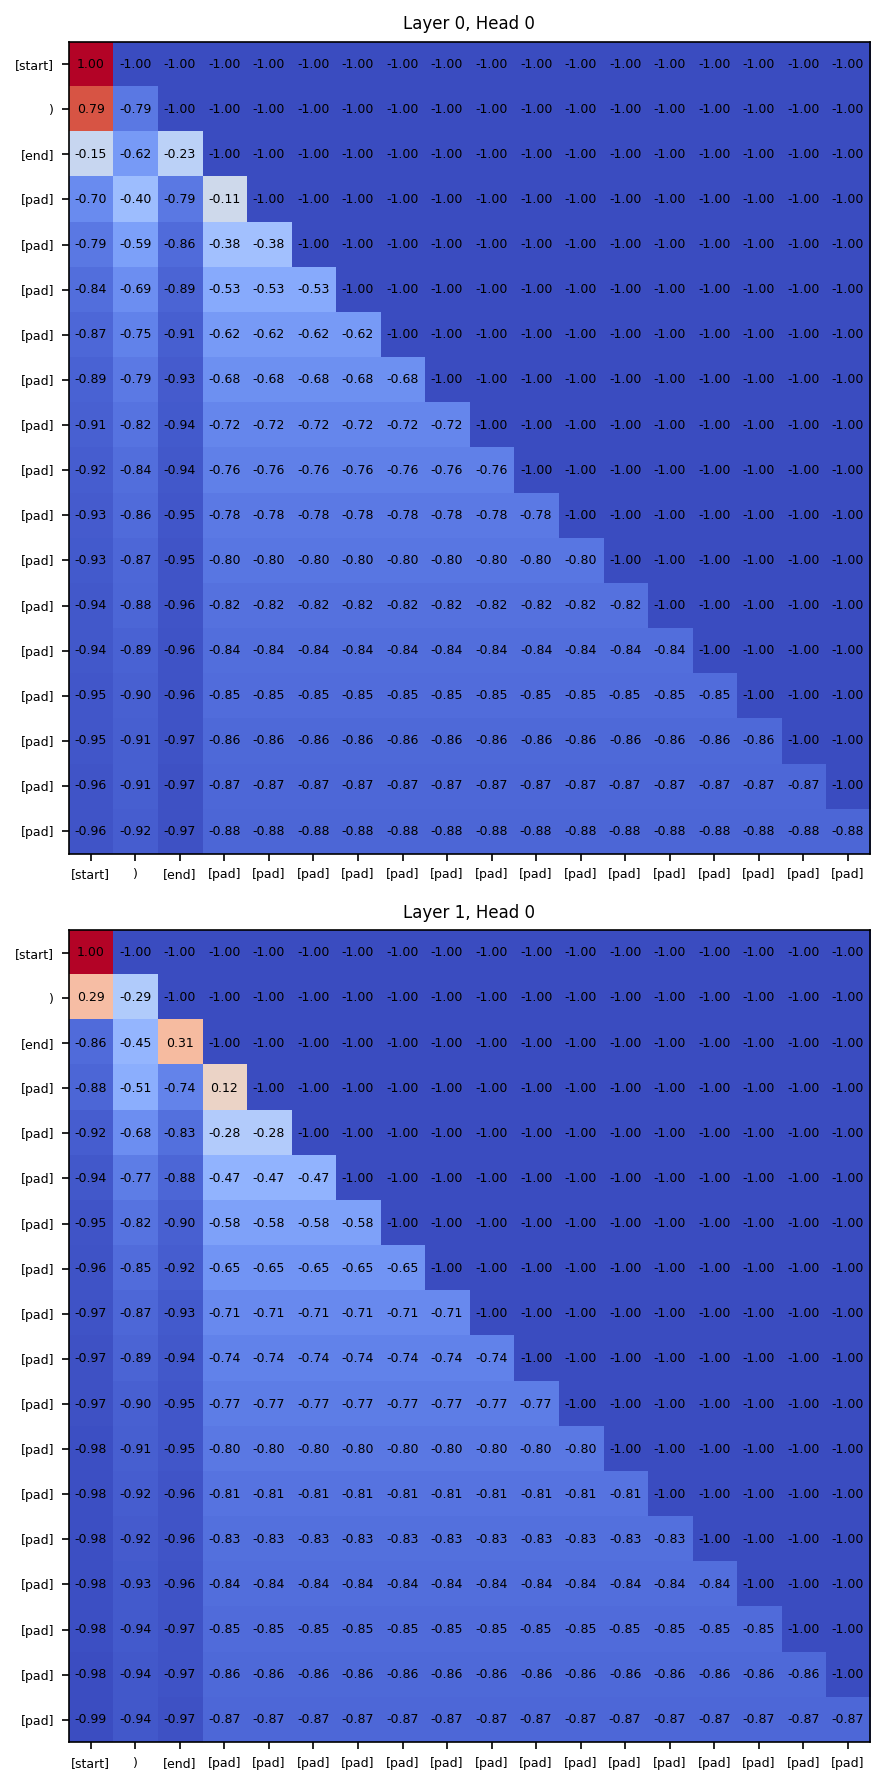

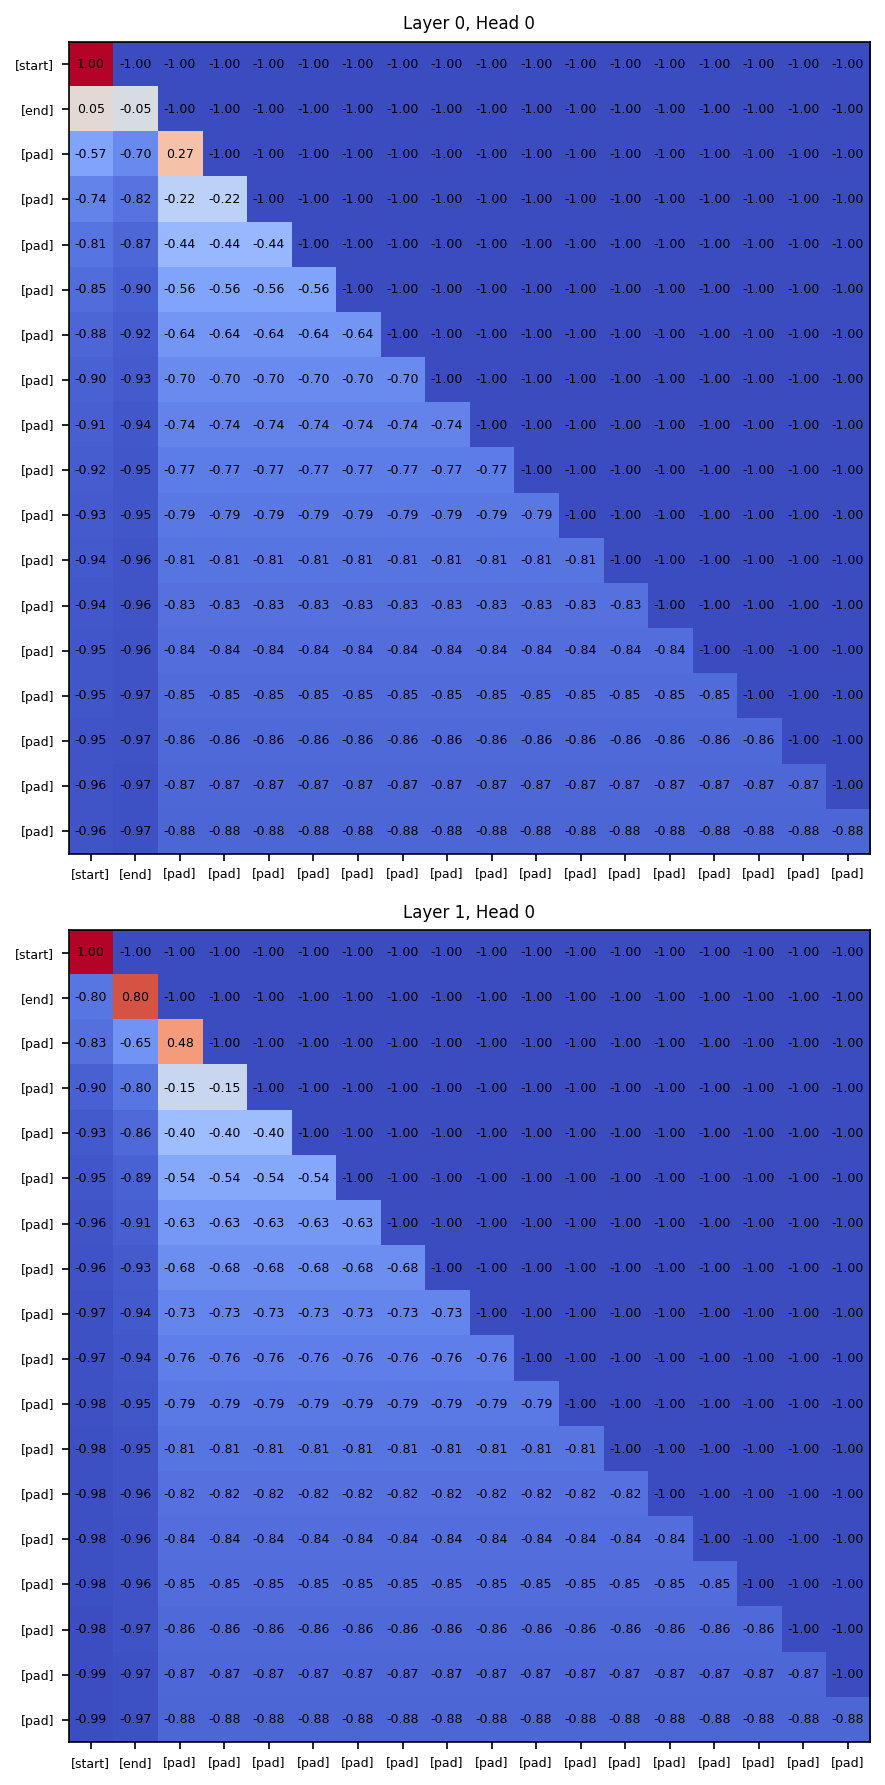

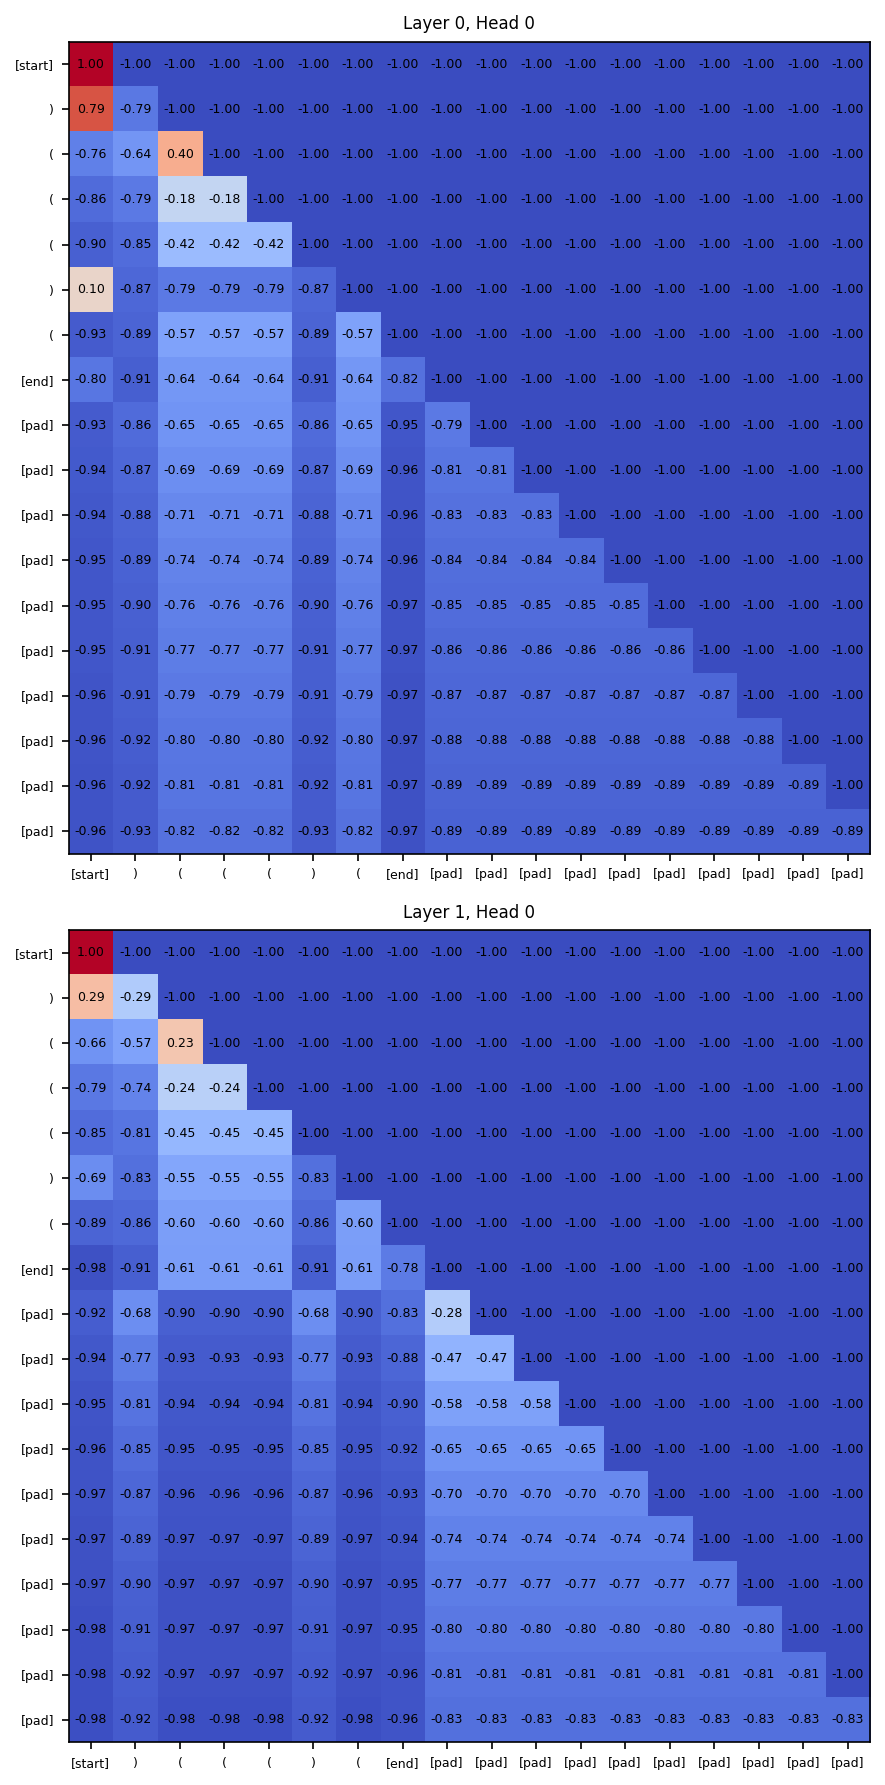

In [31]:
plot_attn_matrices(VOCAB, batch, model_causal, min_max_normalize, causal_mask)

# Hooked Transformer (Bidirectional mask) - Dyck-3 dataset


In [37]:
k = 3

In [38]:
path = generate_dataset(
    n=15_000,
    k=3,
    min_length=0,
    max_length=16,
    balanced=0.5,
)

File data/dyck-3_15000-samples_16-len_p05.jsonl already exists.


In [39]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [40]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-3_15000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 15000/15000 [00:00<00:00, 634353.64it/s]


In [41]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset_dyck_2, [train_size, val_size, test_size]
)

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [43]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [44]:
model = TransformerClassifier(model_config).to(device)

In [45]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [46]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.5048 | Train Accuracy: 80.34%
Train Loss: 0.0409 | Train Accuracy: 87.98%
Train Loss: 0.0153 | Train Accuracy: 91.91%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 64.7707 | Train Acc: 93.53%
Val Loss: 0.2116 | Val Acc: 100.00%
Epoch 2/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0057 | Train Accuracy: 100.00%
Train Loss: 0.0028 | Train Accuracy: 99.98%
Train Loss: 0.0037 | Train Accuracy: 99.99%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 2.0077 | Train Acc: 99.99%
Val Loss: 0.0387 | Val Acc: 100.00%
Epoch 3/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0013 | Train Accuracy: 99.97%
Train Loss: 0.0016 | Train Accuracy: 99.98%
Train Loss: 0.0016 | Train Accuracy: 99.99%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.7443 | Train Acc: 99.99%
Val Loss: 0.0149 | Val Acc: 100.00%
Epoch 4/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 99.97%
Train Loss: 0.0010 | Train Accuracy: 99.98%
Train Loss: 0.0006 | Train Accuracy: 99.99%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.4766 | Train Acc: 99.99%
Val Loss: 0.0085 | Val Acc: 100.00%
Epoch 5/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 99.98%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.3658 | Train Acc: 99.98%
Val Loss: 0.0055 | Val Acc: 100.00%
Epoch 6/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0005 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.3565 | Train Acc: 99.99%
Val Loss: 0.0042 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 99.97%
Train Loss: 0.0003 | Train Accuracy: 99.98%
Train Loss: 0.0003 | Train Accuracy: 99.99%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.2492 | Train Acc: 99.99%
Val Loss: 0.0030 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0747 | Train Acc: 100.00%
Val Loss: 0.0020 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 99.97%
Train Loss: 0.0001 | Train Accuracy: 99.98%
Train Loss: 0.0002 | Train Accuracy: 99.99%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.1047 | Train Acc: 99.99%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0456 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 99.99%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0682 | Train Acc: 99.99%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0272 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0228 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0226 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.0169 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%


In [47]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/150 [00:00<?, ?it/s]

Test Loss: 0.0009 | Test Accuracy: 100.00%
Test Loss: 0.0013 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▃▅▃▆▂▃▂▃▃▂▃▂▂▂▅▅▃▁▂▅▁▂▂▂▃▁▁█▃▁▁▃▅▃▁▇▃▆▂▆
test_acc,▁
test_loss,▁
train/acc,▁▅▆█████████████████████████████████████
train/loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,2e-05
test_acc,100.0


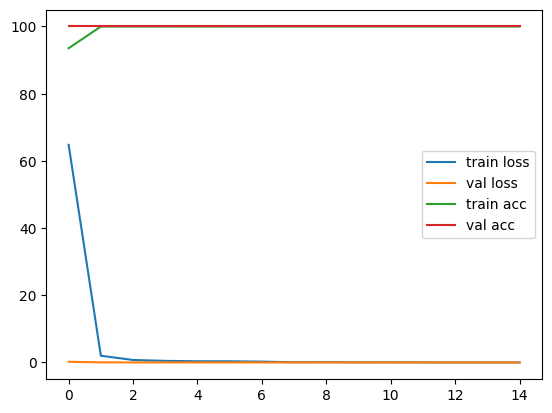

In [48]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [49]:
batch = next(iter(test_dataloader))
batch

[('([()][()])',
  '(){}()(())',
  '()[()()]',
  ')[{[}[(}',
  ')[{[}[(}',
  '{}{{}}[]{}[]{}[]',
  ')[{[}[(}',
  '({[]({}{()})})'),
 tensor([1., 1., 1., 0., 0., 1., 0., 1.], device='cuda:0'),
 tensor([[0., 3., 5., 3., 4., 6., 5., 3., 4., 6., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 3., 4., 7., 8., 3., 4., 3., 3., 4., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 3., 4., 5., 3., 4., 3., 4., 6., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 7., 8., 7., 7., 8., 8., 5., 6., 7., 8., 5., 6., 7., 8., 5., 6., 2.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 3., 7., 5., 6., 3., 7., 8., 7., 3., 4., 8., 4., 8., 4., 2., 1., 1.]],
        device='cuda:0')]

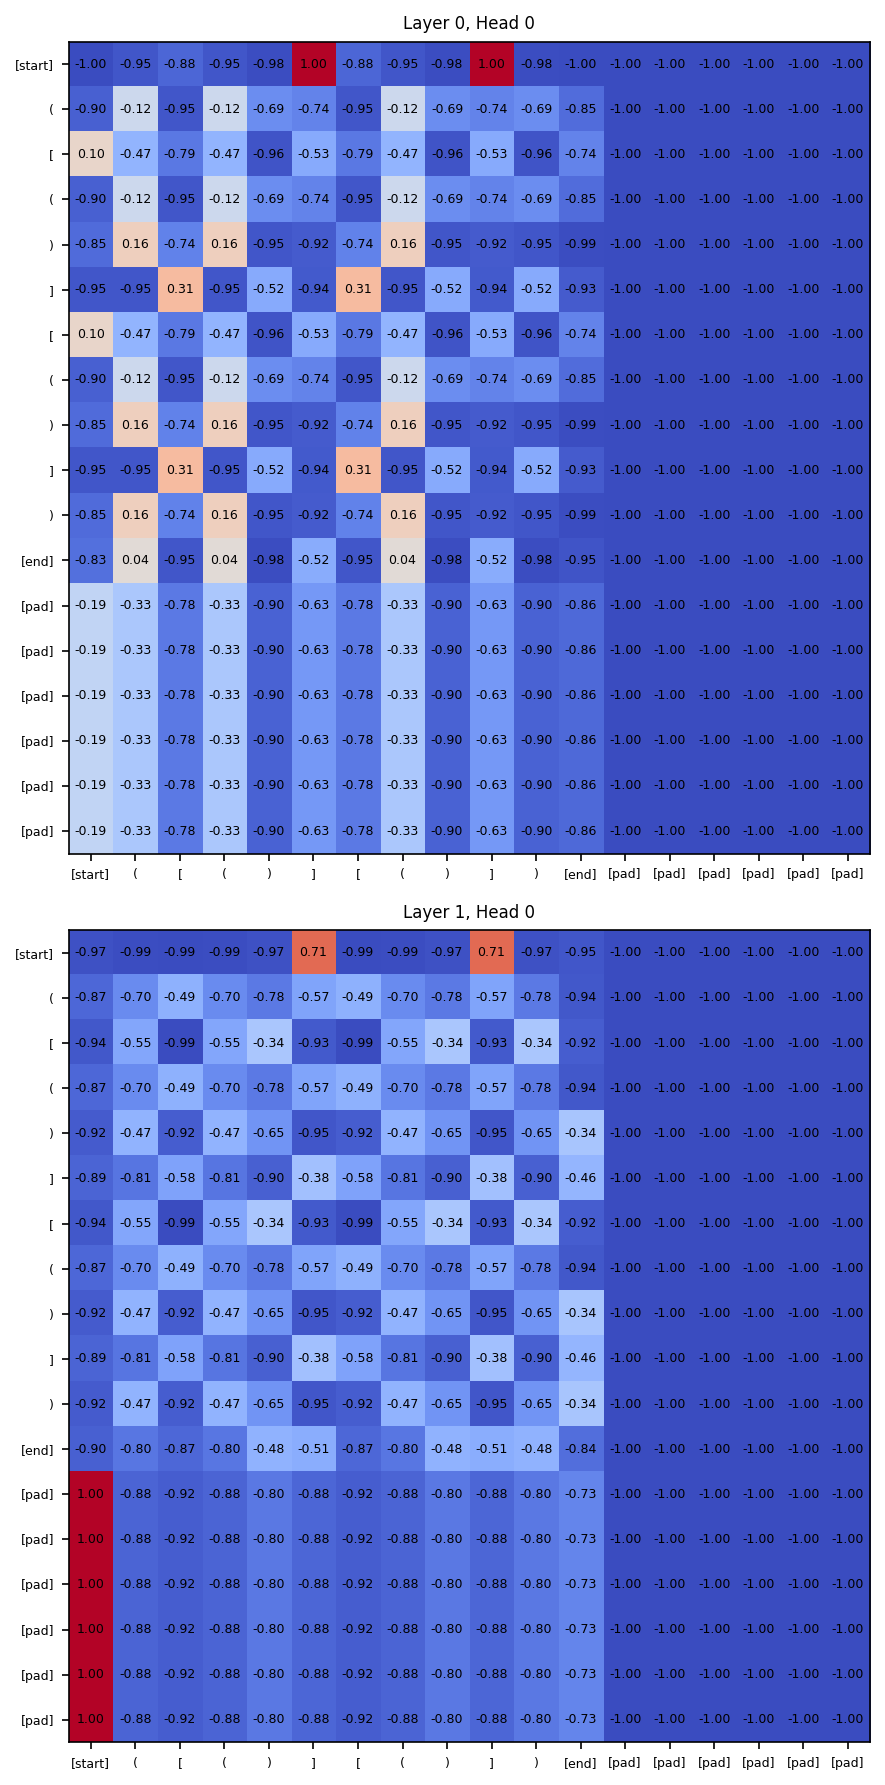

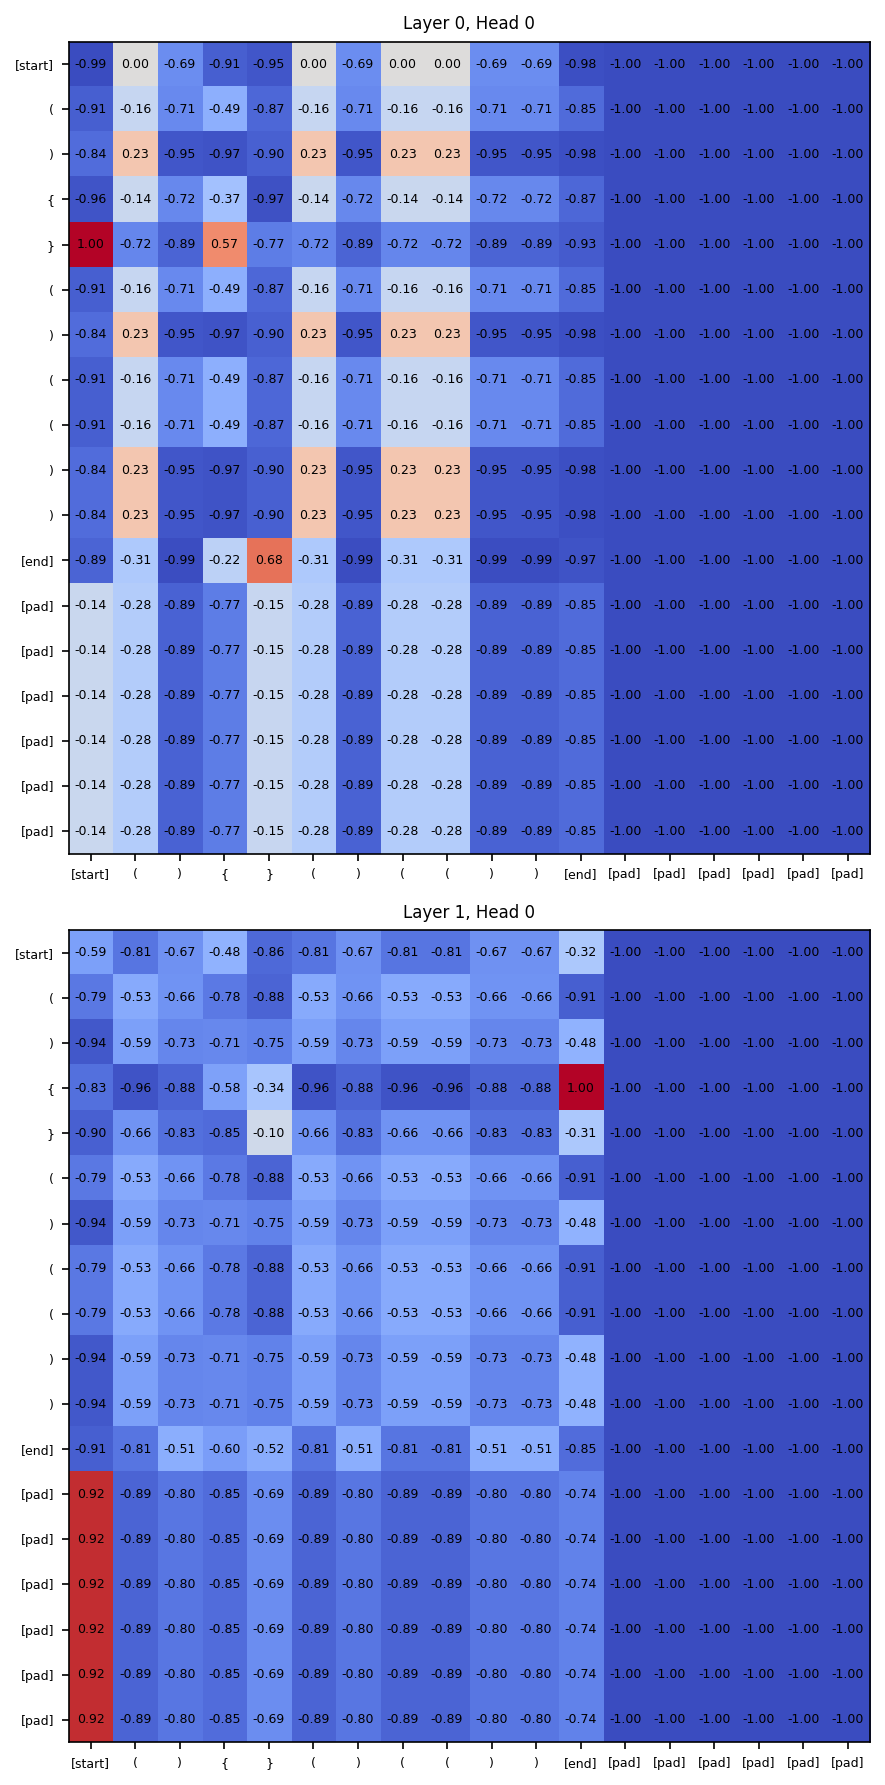

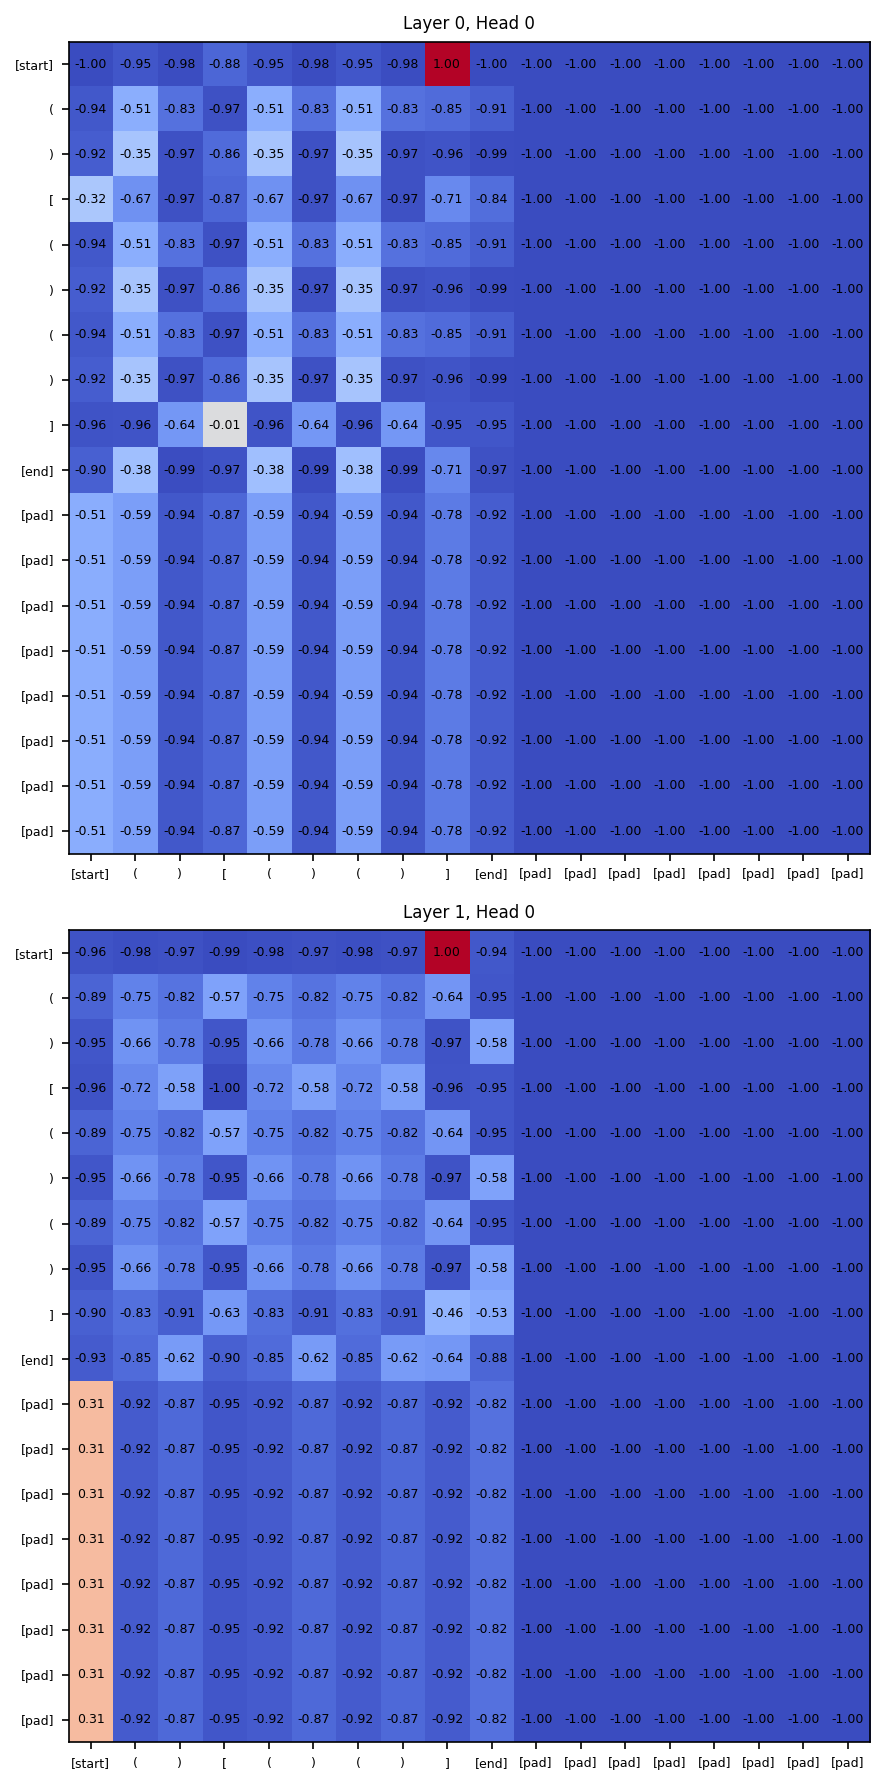

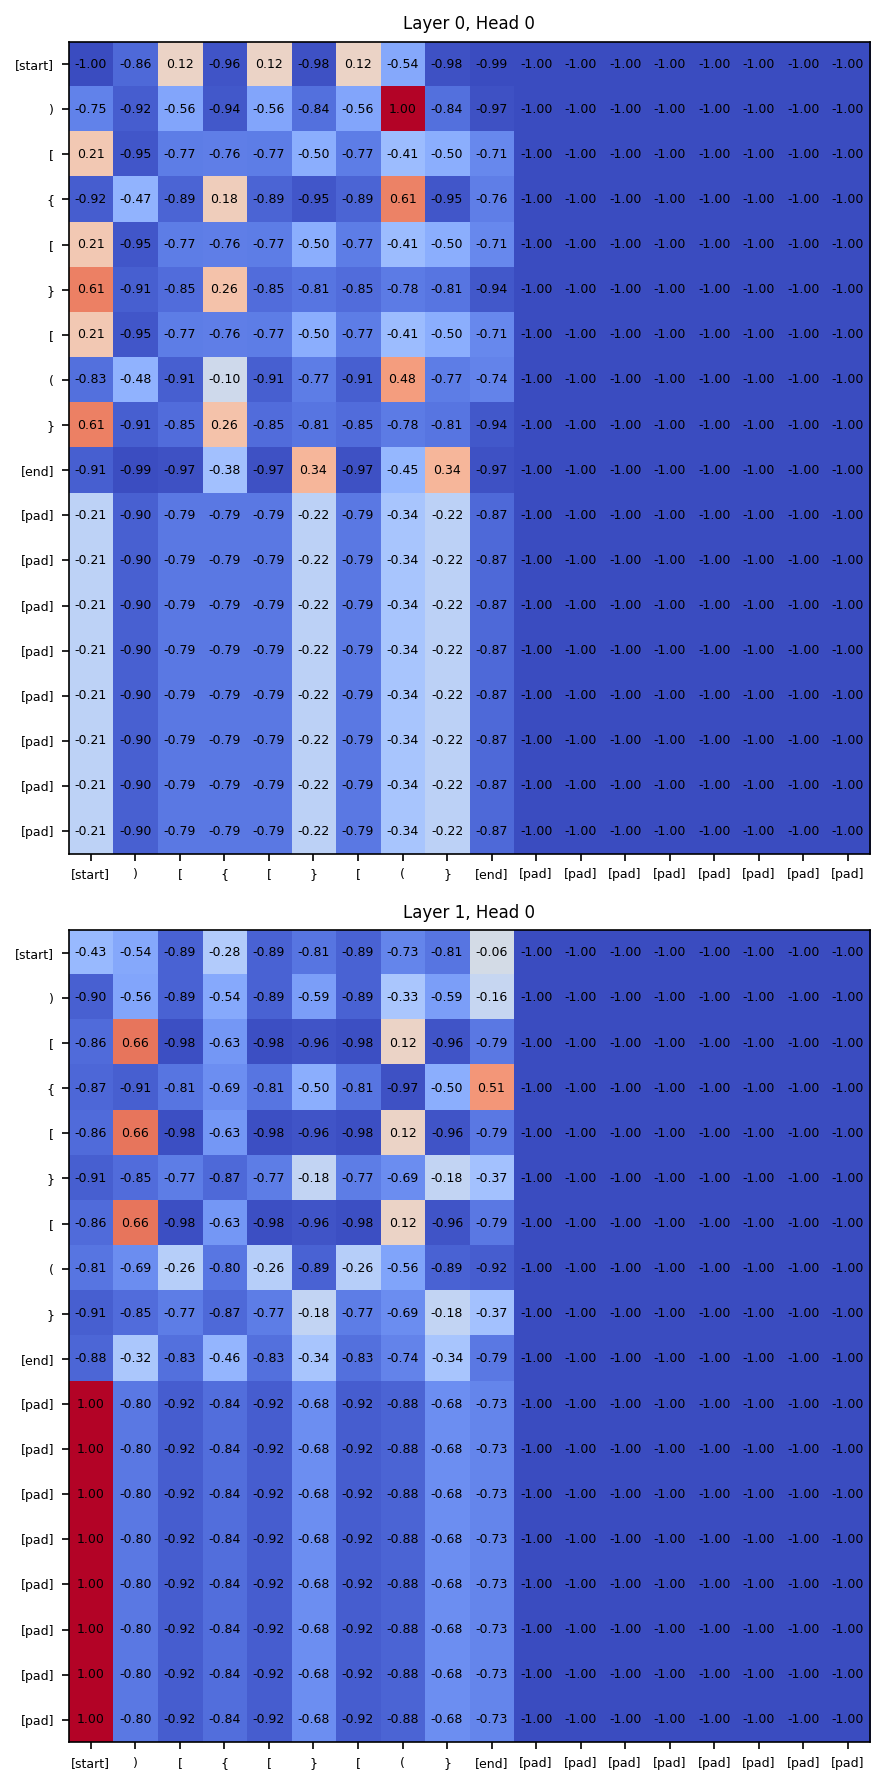

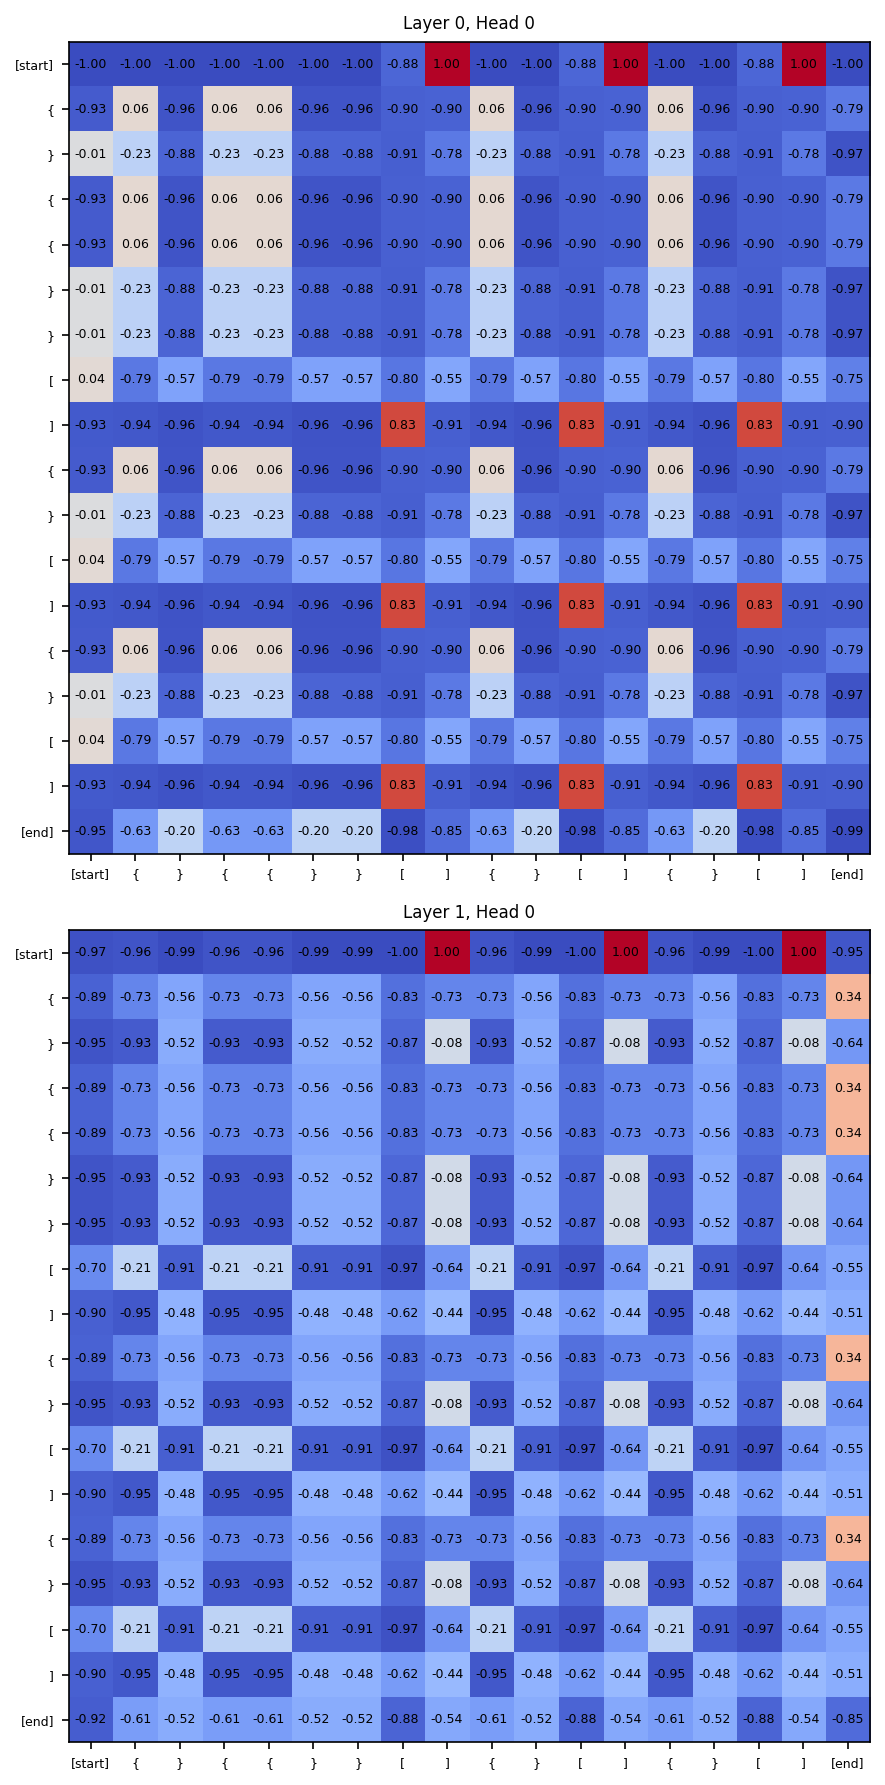

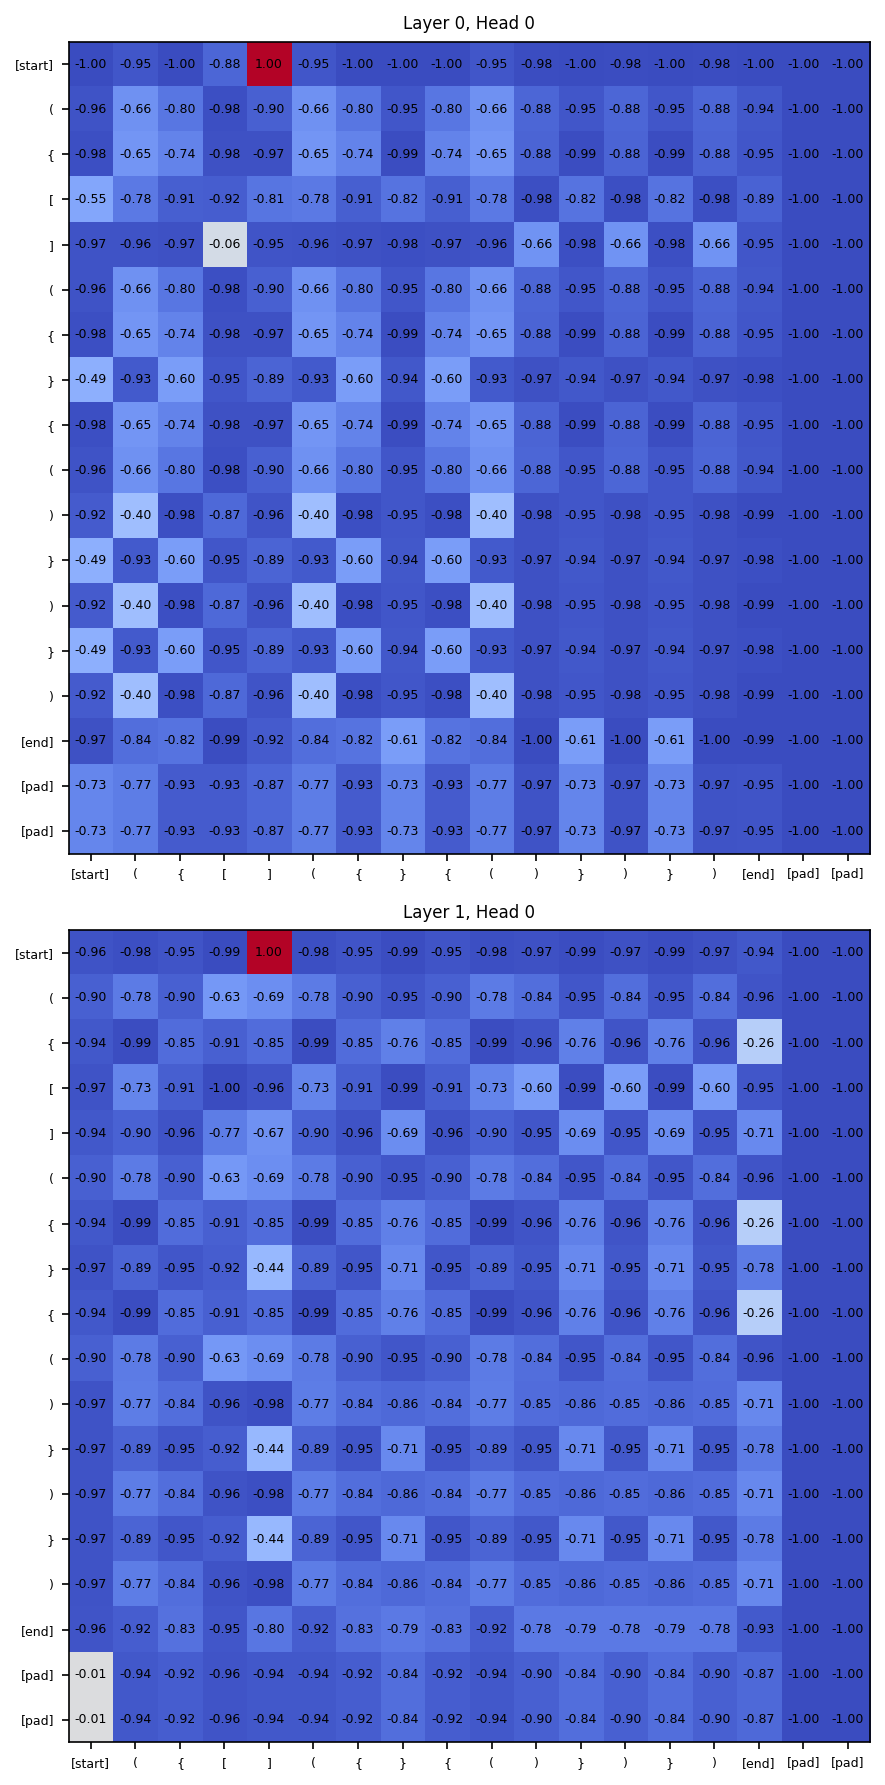

In [50]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)

# Out of Distribution Dyck-3

In [46]:
k = 3

In [47]:
dyck_3_train_dataset = generate_dataset(
    n=50_000,
    k=3,
    min_length=0,
    max_length=96,
    balanced=0.5,
)

File data/dyck-3_50000-samples_96-len_p05.jsonl already exists.


In [48]:
dyck_3_train_dataset

'data/dyck-3_50000-samples_96-len_p05.jsonl'

In [49]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [50]:
dyck_3_train = DyckLanguageDataset(dyck_3_train_dataset, VOCAB).to(device)

train_dataset, val_dataset = random_split(
    dyck_3_train, [0.8, 0.2]
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Loaded 50000 samples from data/dyck-3_50000-samples_96-len_p05.jsonl


Tokenizing strings: 100%|██████████| 50000/50000 [00:00<00:00, 151115.81it/s]


In [54]:
ood_model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=384,
    n_layers=2,
    n_classes=2,
    max_seq_len=128,
)

ood_model = TransformerClassifier(ood_model_config).to(device)
ood_model

train/acc,▆▇█▆▆▆███▆▆▆▆████▇▁▂▄▅▆▆▇█████████▆▅▄▁▁▁
train/loss,▁▁▁▃▁▁▁▁▁▃▂▂▂▁▁▁▁▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁█▃▃▃▃▃▃
val/acc,██████████████▁▁▁▁▁▁█████████████▁▁▁▁▁▁▁
val/loss,▁▁▁▁▁▁▁▄▄▄▄▄▄▄██████▁▁▁▁▁▁▁▁▁▁▁▁▁███████
train/acc,50.12055
train/loss,0.6997
val/acc,50.1
val/loss,0.69246


TransformerClassifier(
  (embedding): Embedding(9, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=384, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=384, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [55]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(ood_model.parameters(), lr=1e-5)

In [56]:
train_loss, train_acc, val_loss, val_acc = ood_model.train_model(
    device=device,
    epochs=25,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.3246 | Train Accuracy: 76.64%
Train Loss: 0.0524 | Train Accuracy: 87.64%
Train Loss: 0.0167 | Train Accuracy: 91.71%
Train Loss: 0.0060 | Train Accuracy: 93.78%
Train Loss: 0.0023 | Train Accuracy: 95.02%
Train Loss: 0.0014 | Train Accuracy: 95.85%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0390 | Validation Accuracy: 100.00%
Train Loss: 72.9232 | Train Acc: 96.01%
Val Loss: 0.0613 | Val Acc: 100.00%
Epoch 2/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0010 | Train Accuracy: 100.00%
Train Loss: 0.0008 | Train Accuracy: 99.99%
Train Loss: 0.0005 | Train Accuracy: 99.99%
Train Loss: 0.0005 | Train Accuracy: 99.99%
Train Loss: 0.0004 | Train Accuracy: 99.99%
Train Loss: 0.0003 | Train Accuracy: 99.99%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0068 | Validation Accuracy: 100.00%
Train Loss: 0.5738 | Train Acc: 100.00%
Val Loss: 0.0108 | Val Acc: 100.00%
Epoch 3/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0022 | Validation Accuracy: 100.00%
Train Loss: 0.1083 | Train Acc: 100.00%
Val Loss: 0.0035 | Val Acc: 100.00%
Epoch 4/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Train Loss: 0.0452 | Train Acc: 100.00%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 5/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0010 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 99.89%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Train Loss: 2.4918 | Train Acc: 99.89%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 6/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0009 | Validation Accuracy: 100.00%
Train Loss: 0.0290 | Train Acc: 100.00%
Val Loss: 0.0015 | Val Acc: 100.00%
Epoch 7/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Train Loss: 0.0246 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 8/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Train Loss: 0.0379 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 9/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0200 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 10/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Train Loss: 0.0170 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 11/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0136 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 12/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0109 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 13/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0079 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 14/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0058 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 15/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0043 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 16/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 99.78%
Train Loss: 0.0000 | Train Accuracy: 99.81%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 6.9355 | Train Acc: 99.82%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 17/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0055 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 18/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0055 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 19/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0054 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 20/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0051 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 21/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0110 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 22/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0071 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 23/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0050 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 24/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0047 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 25/25


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0043 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%


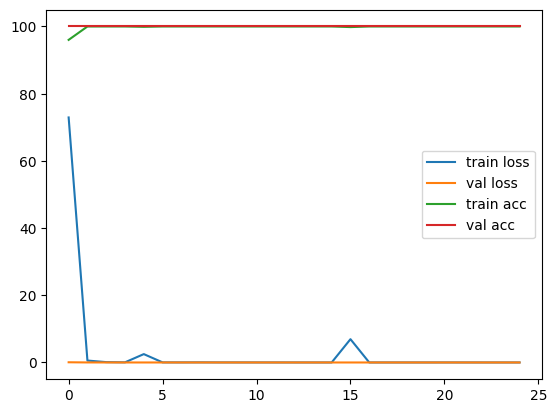

In [57]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [58]:
dyck_3_test_dataset = generate_dataset(
    n=10_000,
    k=3,
    min_length=32,
    max_length=128,
    balanced=0.5,
)

File data/dyck-3_10000-samples_128-len_p05.jsonl already exists.


In [59]:
dyck_3_test = DyckLanguageDataset(dyck_3_test_dataset, VOCAB).to(device)
test_dataloader = DataLoader(dyck_3_test, batch_size=8, shuffle=True)


Loaded 10000 samples from data/dyck-3_10000-samples_128-len_p05.jsonl


Tokenizing strings: 100%|██████████| 10000/10000 [00:00<00:00, 176794.33it/s]


In [60]:
test_loss, test_acc = ood_model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/1250 [00:00<?, ?it/s]

Test Loss: 274.5103 | Test Accuracy: 78.50%
Test Loss: 599.0301 | Test Accuracy: 76.69%
Test Loss: 901.1387 | Test Accuracy: 76.54%
Test Loss: 1210.9405 | Test Accuracy: 76.34%
Test Loss: 1531.8565 | Test Accuracy: 76.10%
Test Loss: 1850.3453 | Test Accuracy: 75.98%
Test Loss: 2183.6514 | Test Accuracy: 75.70%
Test Loss: 2488.7992 | Test Accuracy: 75.73%
Test Loss: 2814.9501 | Test Accuracy: 75.60%
Test Loss: 3137.9053 | Test Accuracy: 75.54%
Test Loss: 3496.4051 | Test Accuracy: 75.23%
Test Loss: 3829.9599 | Test Accuracy: 75.12%
Test Loss: 4014.2908 | Test Acc: 74.98%


test/acc,▃▄██▇▆▅▄▄▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
test/loss,▅▃▃▂▂▃▃▃▄▁▁▃▄▅▂█▃▆▆▅▅▁▆▂▂▃▃▄▂▃▅▆▃▃▃▃▄▂▂▂
test_acc,▁
test_loss,▁
train/acc,▁▆██████████████████████████████████████
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,74.98
test/loss,3.0529
test_acc,74.98


# Long Context Dyck-3

We will now train a hooked transformer with a bidirectional mask, no PE and a max sequence length of 4096.

In [61]:
k = 3
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [62]:
long_ctx_file = generate_dataset(
    n=500_000,
    k=k,
    min_length=0,
    max_length=4096,
    balanced=0.5,
)

File data/dyck-3_500000-samples_4096-len_p05.jsonl already exists.


In [63]:
long_ctx_dataset = DyckLanguageDataset(long_ctx_file, VOCAB).to(device)

Loaded 500000 samples from data/dyck-3_500000-samples_4096-len_p05.jsonl


Tokenizing strings: 100%|██████████| 500000/500000 [00:46<00:00, 10847.14it/s]


In [64]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [65]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [66]:
long_ctx_model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=384,
    n_heads=1,
    dim_ff=768,
    n_layers=2,
    n_classes=2,
    max_seq_len=4096,
)

long_ctx_model = TransformerClassifier(long_ctx_model_config).to(device)

In [67]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(long_ctx_model.parameters(), lr=1e-5)

In [68]:
train_loss, train_acc, val_loss, val_acc = long_ctx_model.train_model(
    device=device,
    epochs=100,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4231 | Train Accuracy: 72.34%
Train Loss: 0.1156 | Train Accuracy: 83.05%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 11.4470 | Validation Accuracy: 97.12%
Train Loss: 98.6159 | Train Acc: 85.79%
Val Loss: 19.2669 | Val Acc: 96.67%
Epoch 2/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0200 | Train Accuracy: 97.28%
Train Loss: 0.0124 | Train Accuracy: 97.92%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.3218 | Validation Accuracy: 100.00%
Train Loss: 16.4077 | Train Acc: 98.32%
Val Loss: 0.4702 | Val Acc: 100.00%
Epoch 3/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0027 | Train Accuracy: 100.00%
Train Loss: 0.0049 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0599 | Validation Accuracy: 100.00%
Train Loss: 1.1262 | Train Acc: 100.00%
Val Loss: 0.0865 | Val Acc: 100.00%
Epoch 4/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0015 | Train Accuracy: 100.00%
Train Loss: 0.0005 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0237 | Validation Accuracy: 100.00%
Train Loss: 0.4003 | Train Acc: 100.00%
Val Loss: 0.0352 | Val Acc: 100.00%
Epoch 5/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0076 | Train Accuracy: 99.91%
Train Loss: 0.0006 | Train Accuracy: 99.95%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0129 | Validation Accuracy: 100.00%
Train Loss: 0.6077 | Train Acc: 99.96%
Val Loss: 0.0206 | Val Acc: 100.00%
Epoch 6/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0077 | Validation Accuracy: 100.00%
Train Loss: 0.1278 | Train Acc: 100.00%
Val Loss: 0.0115 | Val Acc: 100.00%
Epoch 7/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0055 | Validation Accuracy: 100.00%
Train Loss: 0.0782 | Train Acc: 100.00%
Val Loss: 0.0076 | Val Acc: 100.00%
Epoch 8/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0036 | Validation Accuracy: 100.00%
Train Loss: 0.0566 | Train Acc: 100.00%
Val Loss: 0.0053 | Val Acc: 100.00%
Epoch 9/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0026 | Validation Accuracy: 100.00%
Train Loss: 0.0436 | Train Acc: 100.00%
Val Loss: 0.0038 | Val Acc: 100.00%
Epoch 10/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0018 | Validation Accuracy: 100.00%
Train Loss: 0.0310 | Train Acc: 100.00%
Val Loss: 0.0028 | Val Acc: 100.00%
Epoch 11/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0014 | Validation Accuracy: 100.00%
Train Loss: 0.0240 | Train Acc: 100.00%
Val Loss: 0.0021 | Val Acc: 100.00%
Epoch 12/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0188 | Train Acc: 100.00%
Val Loss: 0.0016 | Val Acc: 100.00%
Epoch 13/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Train Loss: 0.0157 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 14/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Train Loss: 0.0130 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 15/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0006 | Train Accuracy: 98.55%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0091 | Validation Accuracy: 100.00%
Train Loss: 13.3667 | Train Acc: 98.84%
Val Loss: 0.0136 | Val Acc: 100.00%
Epoch 16/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0005 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0049 | Validation Accuracy: 100.00%
Train Loss: 0.1123 | Train Acc: 100.00%
Val Loss: 0.0074 | Val Acc: 100.00%
Epoch 17/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0036 | Validation Accuracy: 100.00%
Train Loss: 0.0741 | Train Acc: 100.00%
Val Loss: 0.0054 | Val Acc: 100.00%
Epoch 18/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0029 | Validation Accuracy: 100.00%
Train Loss: 0.0631 | Train Acc: 100.00%
Val Loss: 0.0045 | Val Acc: 100.00%
Epoch 19/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0023 | Validation Accuracy: 100.00%
Train Loss: 0.0489 | Train Acc: 100.00%
Val Loss: 0.0035 | Val Acc: 100.00%
Epoch 20/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0019 | Validation Accuracy: 100.00%
Train Loss: 0.0391 | Train Acc: 100.00%
Val Loss: 0.0029 | Val Acc: 100.00%
Epoch 21/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0016 | Validation Accuracy: 100.00%
Train Loss: 0.0330 | Train Acc: 100.00%
Val Loss: 0.0024 | Val Acc: 100.00%
Epoch 22/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0015 | Validation Accuracy: 100.00%
Train Loss: 0.0325 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 23/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0250 | Train Acc: 100.00%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 24/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Train Loss: 0.0215 | Train Acc: 100.00%
Val Loss: 0.0015 | Val Acc: 100.00%
Epoch 25/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Train Loss: 0.0172 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 26/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0145 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 27/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Train Loss: 0.0122 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 28/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0102 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 29/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0089 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 30/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0071 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 31/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0059 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 32/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0049 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 33/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0043 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 34/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0036 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 35/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0031 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 36/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0027 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 37/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0023 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 38/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0020 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 39/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0017 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 40/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0018 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 41/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0015 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 42/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0012 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 43/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0012 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 44/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0010 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 45/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 46/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 47/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 48/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 49/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0006 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 50/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 51/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 52/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 53/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 54/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 55/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 56/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 57/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.0920 | Train Accuracy: 96.31%
Train Loss: 0.0241 | Train Accuracy: 94.91%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.2253 | Validation Accuracy: 100.00%
Train Loss: 59.7572 | Train Acc: 95.93%
Val Loss: 0.3396 | Val Acc: 100.00%
Epoch 58/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0051 | Train Accuracy: 99.97%
Train Loss: 0.0040 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0313 | Validation Accuracy: 100.00%
Train Loss: 1.7015 | Train Acc: 99.99%
Val Loss: 0.0454 | Val Acc: 100.00%
Epoch 59/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0025 | Train Accuracy: 99.97%
Train Loss: 0.0007 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0125 | Validation Accuracy: 100.00%
Train Loss: 0.4782 | Train Acc: 99.99%
Val Loss: 0.0186 | Val Acc: 100.00%
Epoch 60/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0082 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0066 | Validation Accuracy: 100.00%
Train Loss: 0.2823 | Train Acc: 100.00%
Val Loss: 0.0100 | Val Acc: 100.00%
Epoch 61/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0010 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0038 | Validation Accuracy: 100.00%
Train Loss: 0.1829 | Train Acc: 100.00%
Val Loss: 0.0060 | Val Acc: 100.00%
Epoch 62/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0028 | Validation Accuracy: 100.00%
Train Loss: 0.1087 | Train Acc: 100.00%
Val Loss: 0.0042 | Val Acc: 100.00%
Epoch 63/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0023 | Validation Accuracy: 100.00%
Train Loss: 0.0893 | Train Acc: 100.00%
Val Loss: 0.0034 | Val Acc: 100.00%
Epoch 64/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0016 | Validation Accuracy: 100.00%
Train Loss: 0.0616 | Train Acc: 100.00%
Val Loss: 0.0024 | Val Acc: 100.00%
Epoch 65/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0013 | Validation Accuracy: 100.00%
Train Loss: 0.0632 | Train Acc: 100.00%
Val Loss: 0.0020 | Val Acc: 100.00%
Epoch 66/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0009 | Validation Accuracy: 100.00%
Train Loss: 0.0515 | Train Acc: 100.00%
Val Loss: 0.0014 | Val Acc: 100.00%
Epoch 67/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0411 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 68/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0291 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 69/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0231 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 70/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0186 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 71/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0160 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 72/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0166 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 73/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0112 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 74/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0120 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 75/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0084 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 76/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0085 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 77/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0093 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 78/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0053 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 79/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0046 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 80/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0052 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 81/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.2246 | Train Accuracy: 98.50%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 15.1224 | Train Acc: 98.40%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 82/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 99.97%
Train Loss: 0.0002 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Train Loss: 0.3426 | Train Acc: 99.99%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 83/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0397 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 84/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0370 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 85/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Train Loss: 0.0304 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 86/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0331 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 87/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0253 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 88/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0259 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 89/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0265 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 90/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.2933 | Train Acc: 99.99%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 91/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0253 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 92/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0211 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 93/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0265 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 94/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0172 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 95/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0275 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 96/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0174 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 97/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0116 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 98/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0107 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 99/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0090 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 100/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0088 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%


In [69]:
test_loss, test_acc = long_ctx_model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.0001 | Test Accuracy: 100.00%
Test Loss: 0.0003 | Test Accuracy: 100.00%
Test Loss: 0.0003 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▃▃▃▃▄█▄▂▄▃▁▂▁▂▃▃▄▃▃▃▂▂▃▂▂▂▂▃▂▂▆▄▂▅▃▂▅▂▂▂
test_acc,▁
test_loss,▁
train/acc,▁███████████████████████████████▂███████
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁███████████████████████████████████████
val/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,0.0
test_acc,100.0


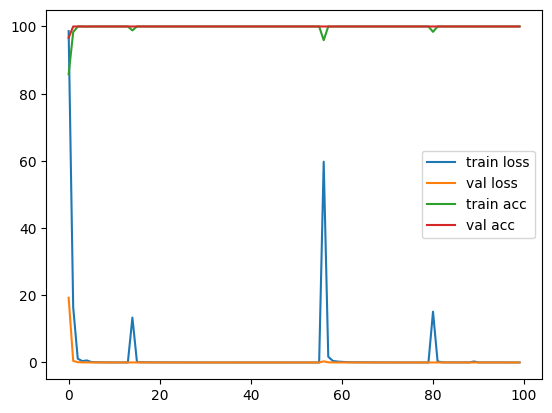

In [70]:
#plot loss and accuracy
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()